<a href="https://colab.research.google.com/github/KaranVyas7/Semantic-Analysis/blob/main/Semantic_analysis_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Semantic Analysis with ANNs

In this notebook we will learn about the basics of **Artificial Neural Networks** by implementing a semantic analysis on movie reviews. Model is trained on the Keras IMDB movie review sentiment dataset, found at https://keras.io/api/datasets/imdb/


##Setup
First we want to import all necessary packages and access our dataset

In [ ]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Importing deep learning libraries
import tensorflow as tf
from tensorflow import keras
from keras import Input
from keras.models import Sequential
from keras.layers import Dense, Flatten
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer


In [ ]:
## Loading dataset

# Setting seed
seed = 12345

test_size = 1000
train_size = 4000

train_list, test_list = keras.datasets.imdb.load_data(seed = seed)
word_dict = keras.datasets.imdb.get_word_index()


# Split to create validation set
x_val_list, x_test_list, y_val, y_test = train_test_split(test_list[0][:test_size*2],
                                                          test_list[1][:test_size*2], test_size = .5, random_state = seed, shuffle = True)

print(f'Training Data Shape: {train_list[0].shape}')
print(f'Validation Data Shape: {x_val_list.shape}')
print(f'Testing Data Shape: {x_test_list.shape}')

Training Data Shape: (25000,)
Validation Data Shape: (1000,)
Testing Data Shape: (1000,)


We can see that the shape of our training dataset is (25000,). This means that we have 25000 reviews. We later cut this down to 4000 (according to what we set 'train_size' to) due to limited RAM available on colab.

You'll notice that there is no second number in the shape of our tuple, this is due to the fact that each sample is a review with a different number of words. However, to feed our data into an artificial neural network, we need a set size of data. How can this be done?

##Creating a Bag of Words Representation

One of the most straightforward methods of turning a dataset of varying length documents (or in this case reviews) into a dataset of a consistent size is the **Bag of Words** representation.

With Bag of Words, we only care about which words show up in a review, and how often they show up. We essentially just see each review as a *bag* filled with *words* rather than actual sentences.

![image.png](https://miro.medium.com/v2/resize:fit:828/format:webp/1*axffCQ9ae0FHXxhuy66FbA.png)

Now, information about each review is not saved as a number encoding of the review itself, but rather a list of all the words our model knows. Each entry is how many times that word appears in the review. For our purposes, we will be using a 'count' method, which just records how many times a word appears in the review, utilizing the CountVectorizer from sklearn.

In [ ]:


# Turning list of numbers into strings for the vectorizer
train_string = [' '.join(map(str, review)) for review in train_list[0][:train_size]]
test_string = [' '.join(map(str, review)) for review in x_test_list]
val_string = [' '.join(map(str, review)) for review in x_val_list]

# Creating a Vectorizer to convert our data into Bag if Words Representations based on word count
vectorizer = CountVectorizer()
vectorizer.fit(train_string)

x_train = vectorizer.transform(train_string)
x_test = vectorizer.transform(test_string)
x_val = vectorizer.transform(val_string)

y_train = train_list[1][:train_size]

In [ ]:
print(f'Training data shape: {x_train.shape}')


Training data shape: (4000, 38469)


**Supervised Learning**

Before going any further, one must understand the types of machine learning. One of the most common types of machine learning is supervised learning. In supervised learning, you are given a X (some set of features) and a y (some target or the thing you want to predict). Each X is mapped to some y. In supervised learning, the goal is to find a model that can accurately estimate this mapping, f(x).

Hence, in supervised learning, we utilize y to be able to build a "function"/model that can accurately predict y from a given x. There are 2 main types of supervised learning: **Classification** and **Regression**.

Classification deals with predicting discrete classes (like this project!)

Regression deals with predicting continuous values such as stock price prediction.

There are also other types of machine learning such as un-supervised learning and semi-supervised learning. We won't be covering these topics as much (or at all).

In this case, we are trying to map each X (the review) to a y (positive or negative sentiment).

## Building and Training our Model

How does the model work?

Before we analyze the model, we need to understand the human brain (just a little). The human body is comprised of millions to billions of neurons that send information to the brain and enable the brain to perform actions. For example, if my friend reaches out to shake my hand, my brain takes this information in via neurons, performs some computation, and sends an output that I need to shake my friend's hand.

This is exactly where the idea of neural networks stems from. Note, this relationship between biological neural networks and the computational neural networks has become weaker and weaker over the years. Most ML practioners don't even use it anymore!

**What happens at each neuron?**

We just discussed where neural networks come from, but we haven't discussed how they work. Specifically, we need to address what happens at each node/neuron/unit.

For the sake of example, let's say that our neuron has 3 inputs: $x_1$, $x_2$, and $x_3$. Then, our neuron performs the following calculation:


$$
out = σ(w_1*x_1 + w_2*x_2 + w_3*x_3 + b)
$$

where

$out$ = output \\
$σ$ = activation function

As you can see, each neuron takes the weighted summation of the inputs. Each input gets multiplied by the corresponding weight. Then, it is summed up and a bias is added. The activation function is some function (i.e sigmoid, relu, etc) that ensures that the model can capture non-linearity. Without the activation function, our model only be able to capture linear relationships since each neuron would be performing linear calculations (i.e if I have $f(x) = 3x$ and $g(x) = 6x$, then $f(g(x)) = 3 * 6x = 9x$, which is still a linear function).

\\

![image.png](https://www.researchgate.net/profile/Facundo-Bre/publication/321259051/figure/fig1/AS:614329250496529@1523478915726/Artificial-neural-network-architecture-ANN-i-h-1-h-2-h-n-o_W640.jpg)

**Universal Function Approximation**

Remember how I earlier said that the goal of supervised learning is to be able to approximate the function f(x), where f(x) maps X to Y? Well it turns out, due to the flexibility of neural networks, we can ,in theory, approximate any function f(x). This is called the **universal function approximation theorem**.

In essence, this theorem states that we could in theory approximate any function f(x) using neural networks.

In [ ]:
# Defining our model structure
model = Sequential()
model.add(Dense(128,activation='relu', input_dim=x_train.shape[1])) # These Dense layers are our neuron layers
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid')) # Sigmoid scales our output between 0 and 1 for classifying 'negative' or 'positive'

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               4924160   
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4932481 (18.82 MB)
Trainable params: 4932481 (18.82 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**We built the model. Now what?**

We understand that each neuron, we are taking a weighted summation of the inputs. But how exactly do we get those weights? Initially, a model is initialized with random weights; however, it is very, very unlikely that these weights are the correct ones. Furthermore, there is no database where we can find the proper weights since there are way too many models and problems. Hence, we need a way to "train" the model. Training the model is process of getting the model to find the weights.

**How do we train the model?**

To train the model, we need to understand 3 concepts: loss function, back propagation, and gradient descent.

**Loss Function:** This is a function that tells us how bad our model is. We want to minimize this function, hence is needs to be differentiable (see below for why).

**Back Propagation:** To minimize the loss function, we can utilize derivatives. Derivatives allow us to understand how each weight/parameter affects the loss. By leveraging the chain rule, back propagation is an algorithm that calculates the derivative of the loss with respect to the weight for each weight.

**Gradient Descent:** Gradient descent is an optimization algorithm that helps us minimize the loss. Essentially, it is the following equation:

$$
w_{new} = w_{old} - α(\frac{d}{dw}Loss(y, \hat{y}))
$$

This equation is for every weight in the neural network. We update each weight based on the above equation. The alpha is the learning rate. It is also a hyper parameter (a parameter that we set and not learn). Typically, we set the learning rate to be anywhere from 0.001 to 0.01. The learning rate scales the derivative so that we don't update our weights by a lot each time. The purpose of the learning rate can be better understood with this analogy:

Imagine you are the top of a hill. You would like to get to the bottom; however, there is dense fog around you. You can't see the bottom, nor can you see which direction to go in. Ideally, you would take small steps in the downward direction ,and eventually, you would reach the bottom. This is exactly what gradient descent does! The hill is the loss function and the learning rate is "how big" our step size is. We don't want to take a big step size because this means we might miss the minimum. The derivatives tell us how "steep" the hill is in each direction (our weights).

To summarize, the neural network utilizes back propagation to calculate the derivatives of the loss with respect to each weight. Then, we update each weight using gradient descent. We run gradient descent for multiple epochs. Epochs are how many times we run the training data through the neural network. You can think of an epoch has a step down the hill.

![image.png](https://sebastianraschka.com/images/faq/gradient-optimization/ball.png)

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))

Epoch 1/10
125/125 [==============================] - 15s 112ms/step - loss: 0.4522 - accuracy: 0.7918 - val_loss: 0.3640 - val_accuracy: 0.8490
Epoch 2/10
125/125 [==============================] - 11s 90ms/step - loss: 0.0810 - accuracy: 0.9768 - val_loss: 0.3989 - val_accuracy: 0.8460
Epoch 3/10
125/125 [==============================] - 10s 77ms/step - loss: 0.0122 - accuracy: 0.9980 - val_loss: 0.5343 - val_accuracy: 0.8550
Epoch 4/10
125/125 [==============================] - 9s 70ms/step - loss: 0.0023 - accuracy: 0.9998 - val_loss: 0.5879 - val_accuracy: 0.8490
Epoch 5/10
125/125 [==============================] - 9s 68ms/step - loss: 6.6728e-04 - accuracy: 1.0000 - val_loss: 0.6382 - val_accuracy: 0.8490
Epoch 6/10
125/125 [==============================] - 7s 56ms/step - loss: 3.1809e-04 - accuracy: 1.0000 - val_loss: 0.6821 - val_accuracy: 0.8520
Epoch 7/10
125/125 [==============================] - 6s 49ms/step - loss: 1.7973e-04 - accuracy: 1.0000 - val_loss: 0.7186 - val_

In [ ]:
# Let's see how the model performs on the test data
model.evaluate(x=x_test, y=y_test, batch_size = 32)

32/32 [==============================] - 0s 3ms/step - loss: 0.8191 - accuracy: 0.8550


[0.8190799355506897, 0.8550000190734863]

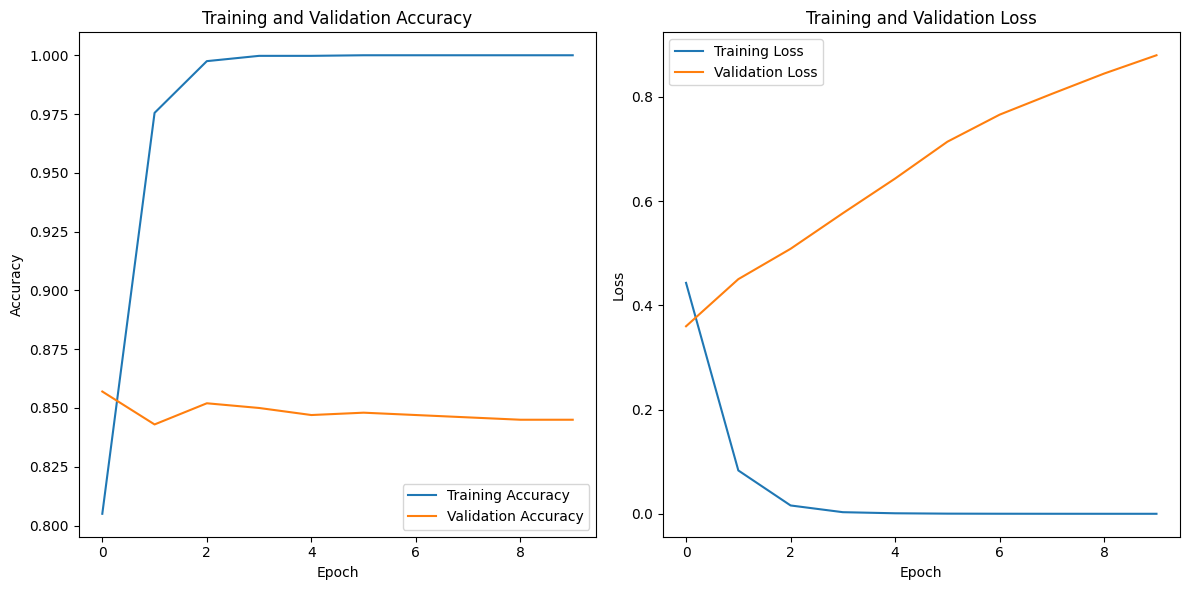

In [ ]:
# Plot accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

The model has a loss of 0.8191 and an accuracy of 85.50%. Clearly, there is a a gap between the metrics of the model on the test data and the metrics of the model on the training data. This is because of **overfitting**.

Overfitting is a concept in machine learning which means that the model "memorizes" the training data rather than understanding patterns. Here is an example that better illustrates this concept:

Imagine you are studying for a test. Instead of studying the concepts, you memorize the practice problems. When it comes time to the test, in all liklihood, you will fail because the test isn't the exact same as the practice problems. This is an example of overfitting. The model does really well on the training data, but not as well on the test data.

To minimize overfitting, you can do multiple things:
1. Get more data
2. Regularize, penalize the model or add constraints to the weights

Underfitting is the complete opposite: the model does poorly on the training data and on the testing data.

To minimize underfitting, you can do multiple things:
1. Build a more complex model
2. Get more data

## Test the model on our own reviews!

In [ ]:
def input_to_encoding(input: str, word_dict):

    # Convert input string to lowercase and remove non-alphanumeric characters
    cleaned_string = ''.join(char.lower() if char.isalnum() or char.isspace() else ' ' for char in input)

    # Split the cleaned string into a list of words
    words = cleaned_string.split()

    # Map each word to its corresponding integer value using the provided dictionary
    encoding = [str(word_dict.get(word, 0)) for word in words]

    encoding_string = [' '.join(encoding)]

    return encoding_string


In [ ]:
review = "That was an absolute dumpster fire from start to finish. If there were an olympics \
            competition for most meaningless movies to watch, \
            this movie would win gold, silver, and bronze all on its own."

# Encode our own review
encoding = input_to_encoding(review, word_dict)

# Transform it using the vectorizer
input = vectorizer.transform(encoding)

# Feed our encoded review into the model to predict the sentiment
prediction = model.predict(input)

print("Model Prediction: ", 'Positive' if prediction==1 else 'Negative')

1/1 [==============================] - 0s 9ms/step
Model Prediction:  Negative
